# Lungs Pathological Condition Diagnosis using Chest X-rays

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util

### Loading the Datasets

In [33]:
train_df = pd.read_csv("nih/train-small.csv")
valid_df = pd.read_csv("nih/valid-small.csv")

test_df = pd.read_csv("nih/test.csv")

train_df.T.head(20)

0                 1                 2    \
Image               00008270_015.png  00029855_001.png  00001297_000.png   
Atelectasis                        0                 1                 0   
Cardiomegaly                       0                 0                 0   
Consolidation                      0                 0                 0   
Edema                              0                 0                 0   
Effusion                           0                 1                 0   
Emphysema                          0                 0                 0   
Fibrosis                           0                 0                 0   
Hernia                             0                 0                 0   
Infiltration                       0                 1                 0   
Mass                               0                 0                 0   
Nodule                             0                 0                 0   
PatientId                       8270             29855              1297   
Pleural_Thickening                 0                 0                 1   
Pneumonia                          0                 0                 0   
Pneumothorax                       0                 0                 0   

                                 3                 4                 5    \
Image               00012359_002.png  00017951_001.png  00001232_002.png   
Atelectasis                        0                 0                 1   
Cardiomegaly                       0                 0                 1   
Consolidation                      0                 0                 0   
Edema                              0                 0                 0   
Effusion                           0                 0                 1   
Emphysema                          0                 0                 0   
Fibrosis                           0                 0                 0   
Hernia                             0                 0                 0   
Infiltration                       0                 1                 1   
Mass                               0                 0                 0   
Nodule                             0                 0                 0   
PatientId                      12359             17951              1232   
Pleural_Thickening                 0                 0                 0   
Pneumonia                          0                 0                 0   
Pneumothorax                       0                 0                 0   

                                 6                 7                 8    \
Image               00017135_000.png  00027235_000.png  00014197_007.png   
Atelectasis                        0                 0                 0   
Cardiomegaly                       0                 0                 0   
Consolidation                      0                 0                 0   
Edema                              0                 0                 0   
Effusion                           0                 0                 0   
Emphysema                          0                 0                 0   
Fibrosis                           0                 0                 0   
Hernia                             0                 0                 0   
Infiltration                       0                 0                 0   
Mass                               0                 0                 0   
Nodule                             0                 0                 0   
PatientId                      17135             27235             14197   
Pleural_Thickening                 0                 0                 0   
Pneumonia                          0                 0                 0   
Pneumothorax                       0                 0                 0   

                                 9    ...               990               991  \
Image               00011584_002.png  ...  00019382_000.png  00001805_004

In [3]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

### Image Preprocessing

#### Training data

In [4]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

####  Testing and Validation data


The same generator as for the training data cannot be used for testing and validation


In [5]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [6]:
IMAGE_DIR = "nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Let's peek into what the generator gives our model during training and validation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


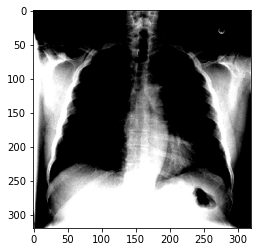

In [7]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

## Model Development

Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

### 1 - Class Imbalance


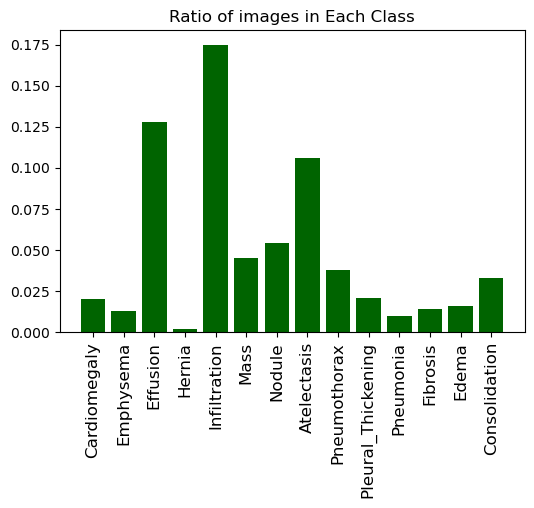

In [34]:
from matplotlib.pyplot import figure

figure(figsize=(6,4), dpi=100)
plt.xticks(rotation=90, size = 12)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0), color='darkgreen')
plt.title("Ratio of images in Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

### 2 - Computing Class Frequencies
Complete the function below to calculate these frequences for each label in our dataset.

In [9]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [10]:
# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


Now we'll compute frequencies for our training data.

In [11]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

Let's visualize these two contribution ratios next to each other for each of the pathologies:

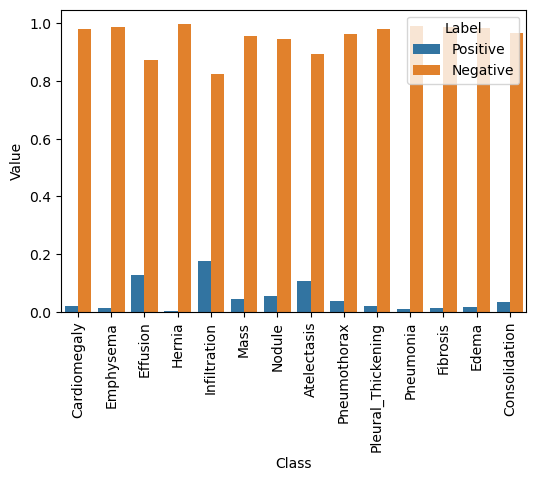

In [12]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
figure(figsize=(6,4), dpi=100)
plt.xticks(rotation=90, size = 10)
f = sns.barplot(x="Class", y="Value", data=data, hue='Label')

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [13]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other again:

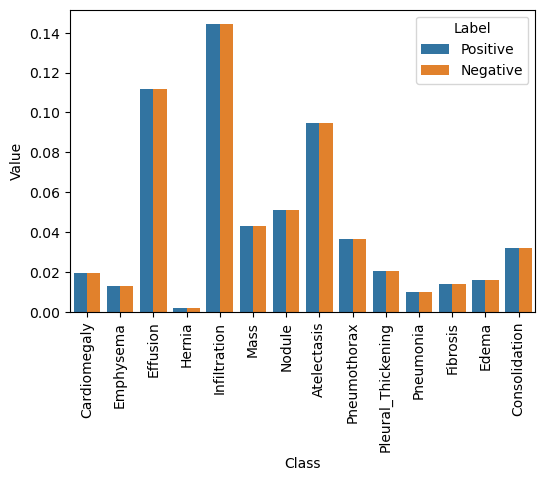

In [14]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
figure(figsize=(6,4), dpi=100)
plt.xticks(rotation=90, size=10)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

### 3 - Weighted Loss
We will fill out the `weighted_loss` function below to return a loss function that calculates the weighted loss for each batch. For a multi-class loss, we add up the average loss for each individual class. Note that we also want to add a small value, $\epsilon$, to the predicted values before taking their logs. This is simply to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.


In [15]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon))) #complete this line
        return loss
    
    return weighted_loss

<a name='3-3'></a>
### 3.3 DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

**Dense Convolutional Network (DenseNet), connects each layer to every other layer in a feed-forward fashion.**

![alt](https://pytorch.org/assets/images/densenet1.png)

![alt](https://pytorch.org/assets/images/densenet2.png)

In [16]:
# create the base pre-trained model
base_model = DenseNet121(weights='./nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


A pretrained model weiight has been introduced here in this notebook since the model training takes a very long time hence for the ease managing the outputs from further results, a pretrained model of the trained model is used.

In [17]:
model.load_weights("./nih/pretrained_model.h5")

## 4 Prediction and Evaluation

**Note:** The following cell can take about 4 minutes to run.

In [18]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

Instructions for updating:
Please use Model.predict, which supports generators.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


### 4.1 - ROC Curve and AUROC

We will use the `util.get_roc_curve()` function which has been provided for you in `util.py`. 

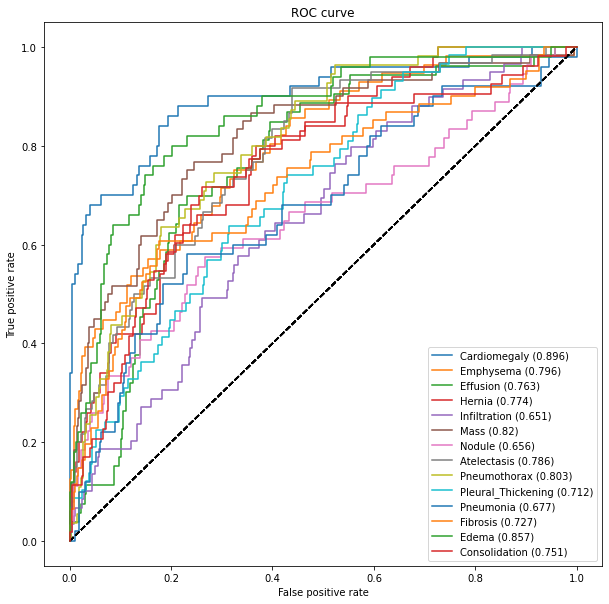

In [19]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

The performance to the AUCs reported in the original ChexNeXt paper in the table below: 

For reference, here's the AUC figure from the ChexNeXt paper which includes AUC values for their model as well as radiologists on this dataset:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="80%">

This method does take advantage of a few other tricks such as self-training and ensembling as well, which can give a significant boost to the performance.

### 4.2 GradCAM - generating heatmaps for explanations


One of the challenges of using deep learning in medicine is that the complex architecture used for neural networks makes them much harder to interpret compared to traditional machine learning models (e.g. linear models). 

One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM). 
- Class activation maps are useful for understanding where the model is "looking" when classifying an image. 

In this section we will use a [GradCAM's](https://arxiv.org/abs/1610.02391) technique to produce a heatmap highlighting the important regions in the image for predicting the pathological condition. 
- This is done by extracting the gradients of each predicted class, flowing into our model's final convolutional layer. Look at the `util.compute_gradcam` which has been provided for you in `util.py` to see how this is done with the Keras framework. 

It is worth mentioning that GradCAM does not provide a full explanation of the reasoning for each classification probability. 
- However, it is still a useful tool for "debugging" our model and augmenting our prediction so that an expert could validate that a prediction is indeed due to the model focusing on the right regions of the image.

In [20]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

First we will load the small training set and setup to look at the 4 classes with the highest performing AUC measures.

In [21]:
df = pd.read_csv("nih/train-small.csv")
IMAGE_DIR = "nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show_1 = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]#[::-1])[:5]
labels_to_show_2 = np.take(labels, np.argsort(auc_rocs)[::-1])[4:8]#[::-1])[:5]
labels_to_show_3 = np.take(labels, np.argsort(auc_rocs)[::-1])[8:12]#[::-1])[:5]
labels_to_show_4 = np.take(labels, np.argsort(auc_rocs)[::-1])[12:]#[::-1])[:5]

Now let's look at a few specific images.

Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation
Generating gradcam for class Infiltration
Generating gradcam for class Nodule


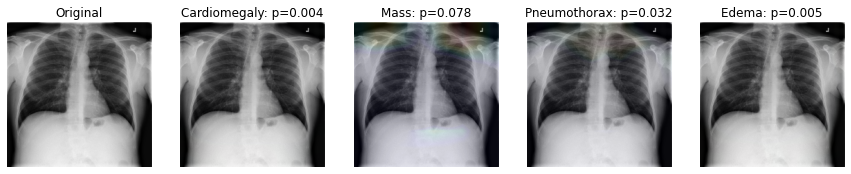

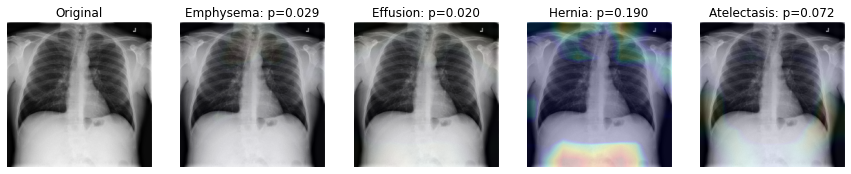

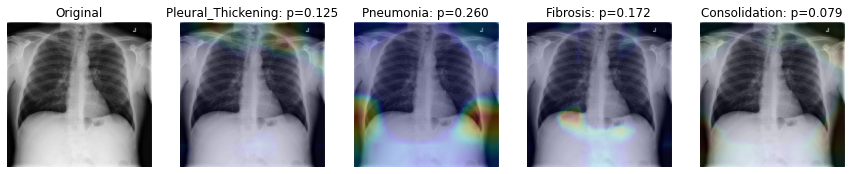

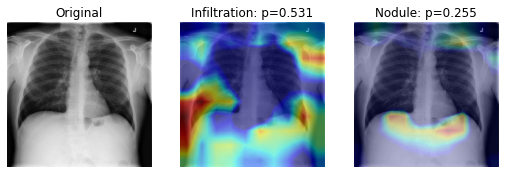

In [22]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show_1)
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show_2)
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show_3)
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show_4)

Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation
Generating gradcam for class Infiltration
Generating gradcam for class Nodule


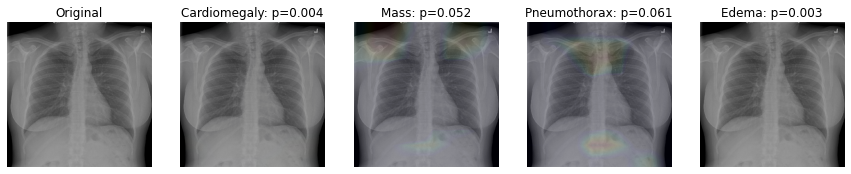

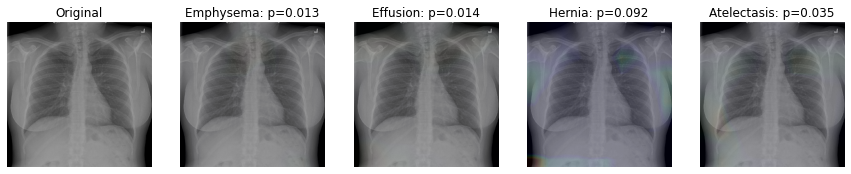

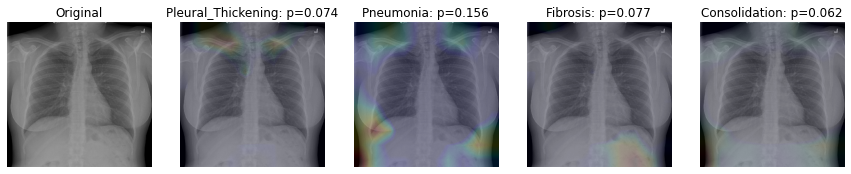

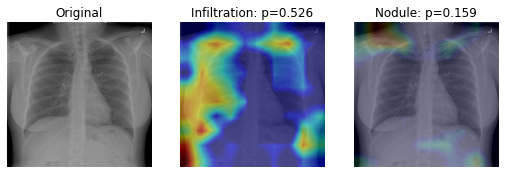

In [23]:
util.compute_gradcam(model, '00030629_000.png', IMAGE_DIR, df, labels, labels_to_show_1)
util.compute_gradcam(model, '00030629_000.png', IMAGE_DIR, df, labels, labels_to_show_2)
util.compute_gradcam(model, '00030629_000.png', IMAGE_DIR, df, labels, labels_to_show_3)
util.compute_gradcam(model, '00030629_000.png', IMAGE_DIR, df, labels, labels_to_show_4)

Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation
Generating gradcam for class Infiltration
Generating gradcam for class Nodule


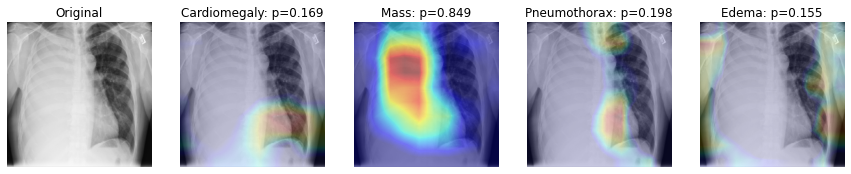

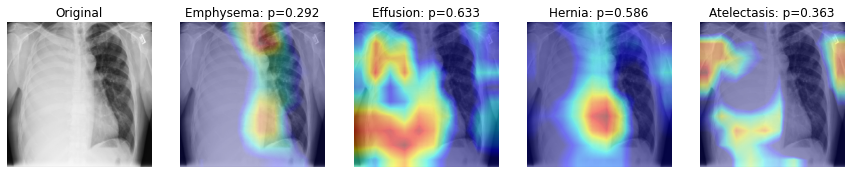

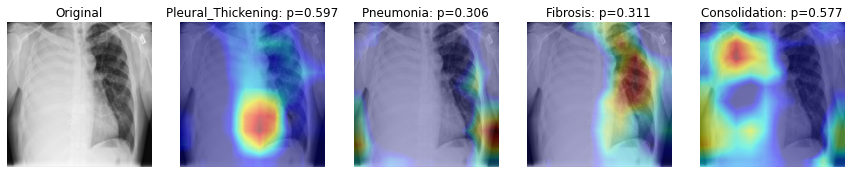

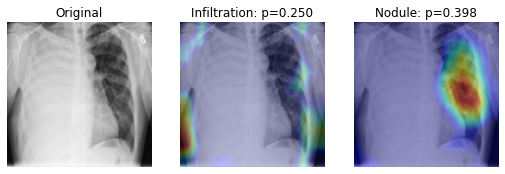

In [24]:
util.compute_gradcam(model, '00009553_001.png', IMAGE_DIR, df, labels, labels_to_show_1)
util.compute_gradcam(model, '00009553_001.png', IMAGE_DIR, df, labels, labels_to_show_2)
util.compute_gradcam(model, '00009553_001.png', IMAGE_DIR, df, labels, labels_to_show_3)
util.compute_gradcam(model, '00009553_001.png', IMAGE_DIR, df, labels, labels_to_show_4)

Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation
Generating gradcam for class Infiltration
Generating gradcam for class Nodule


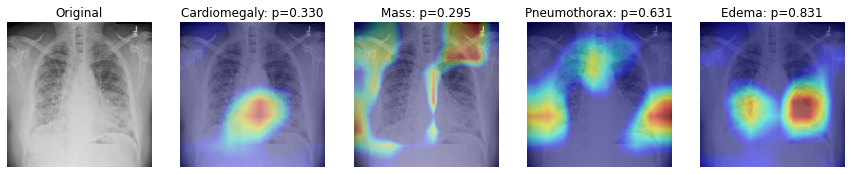

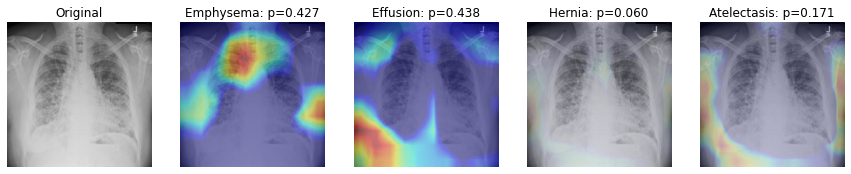

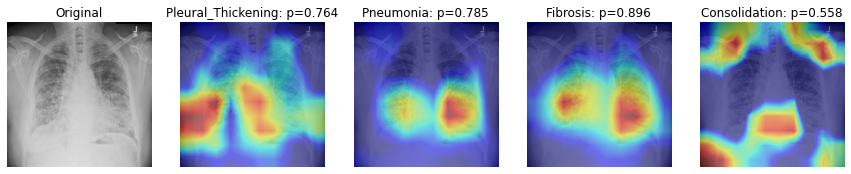

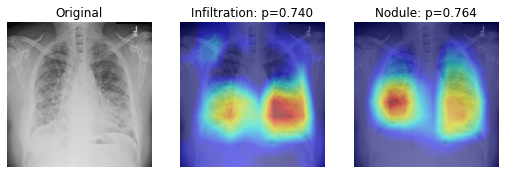

In [25]:
util.compute_gradcam(model, '00007069_000.png', IMAGE_DIR, df, labels, labels_to_show_1)
util.compute_gradcam(model, '00007069_000.png', IMAGE_DIR, df, labels, labels_to_show_2)
util.compute_gradcam(model, '00007069_000.png', IMAGE_DIR, df, labels, labels_to_show_3)
util.compute_gradcam(model, '00007069_000.png', IMAGE_DIR, df, labels, labels_to_show_4)

Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation
Generating gradcam for class Infiltration
Generating gradcam for class Nodule


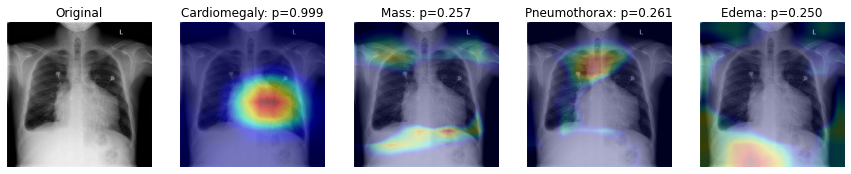

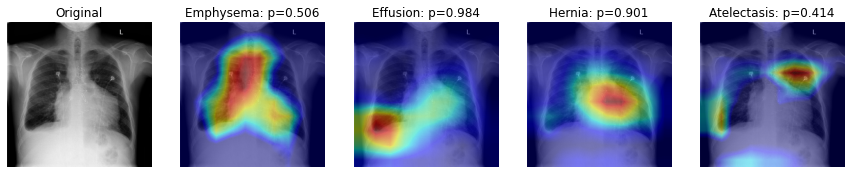

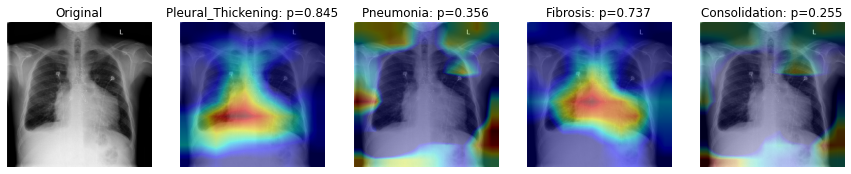

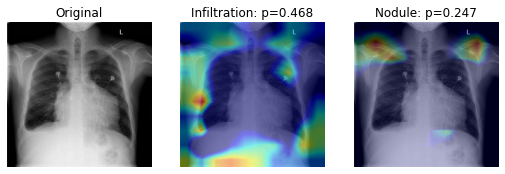

In [26]:
util.compute_gradcam(model, '00000457_002.png', IMAGE_DIR, df, labels, labels_to_show_1)
util.compute_gradcam(model, '00000457_002.png', IMAGE_DIR, df, labels, labels_to_show_2)
util.compute_gradcam(model, '00000457_002.png', IMAGE_DIR, df, labels, labels_to_show_3)
util.compute_gradcam(model, '00000457_002.png', IMAGE_DIR, df, labels, labels_to_show_4)

In [ ]:
cardiomegly, plural 

Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation
Generating gradcam for class Infiltration
Generating gradcam for class Nodule


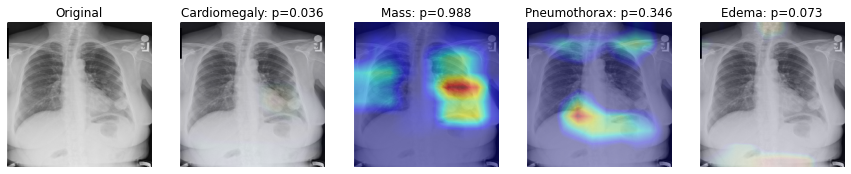

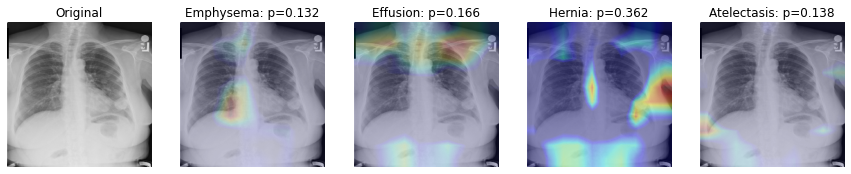

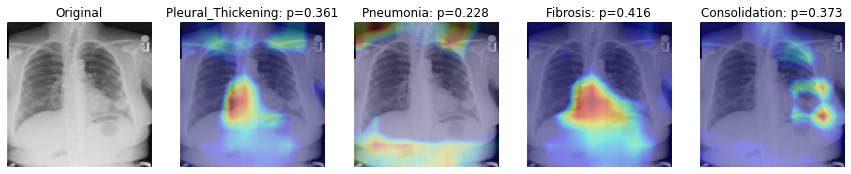

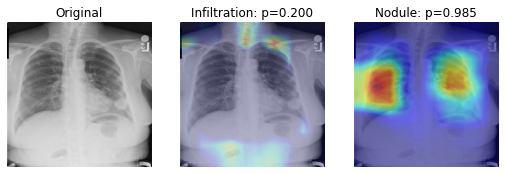

In [27]:
util.compute_gradcam(model, '00005904_001.png', IMAGE_DIR, df, labels, labels_to_show_1)
util.compute_gradcam(model, '00005904_001.png', IMAGE_DIR, df, labels, labels_to_show_2)
util.compute_gradcam(model, '00005904_001.png', IMAGE_DIR, df, labels, labels_to_show_3)
util.compute_gradcam(model, '00005904_001.png', IMAGE_DIR, df, labels, labels_to_show_4)

Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation
Generating gradcam for class Infiltration
Generating gradcam for class Nodule


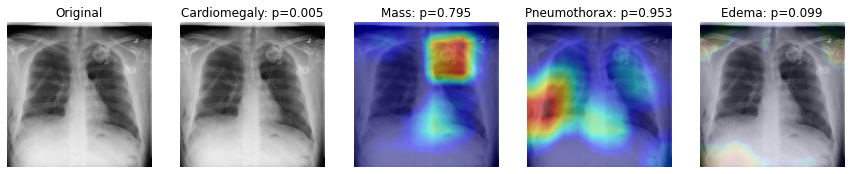

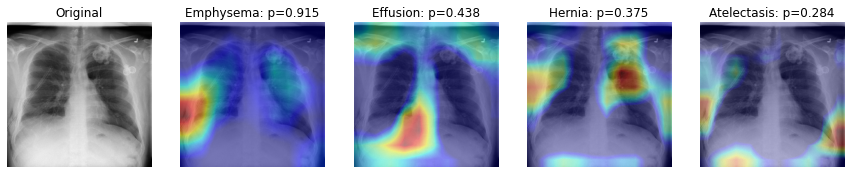

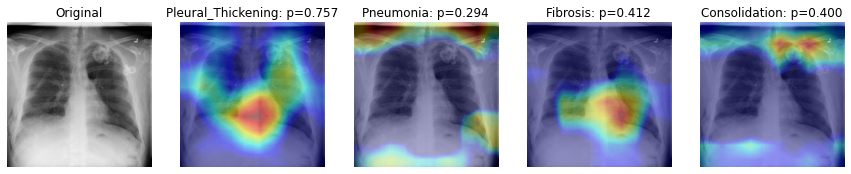

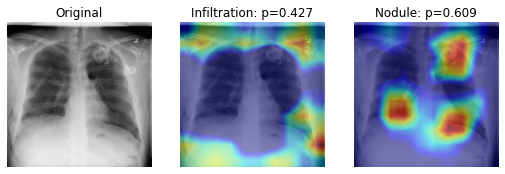

In [28]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show_1)
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show_2)
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show_3)
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show_4)

Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation
Generating gradcam for class Infiltration
Generating gradcam for class Nodule


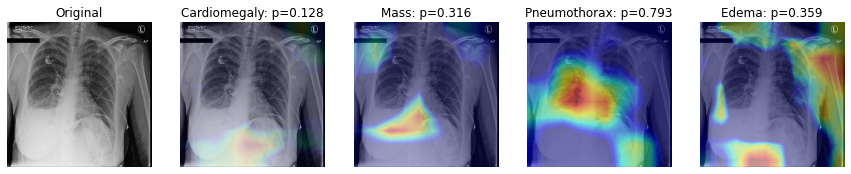

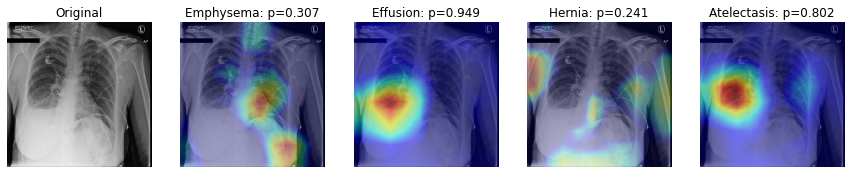

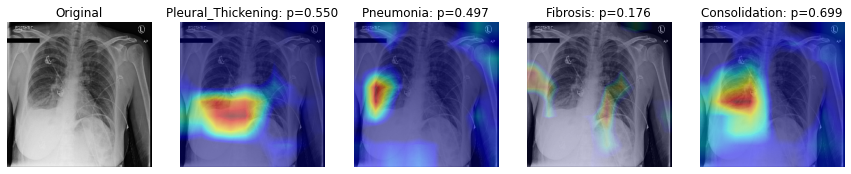

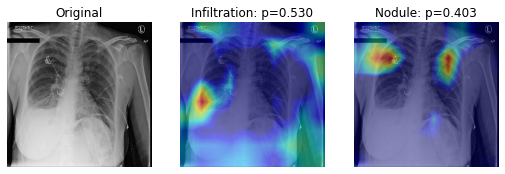

In [29]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show_1)
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show_2)
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show_3)
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show_4)

Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation
Generating gradcam for class Infiltration
Generating gradcam for class Nodule


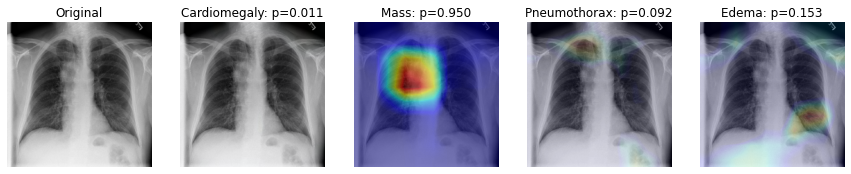

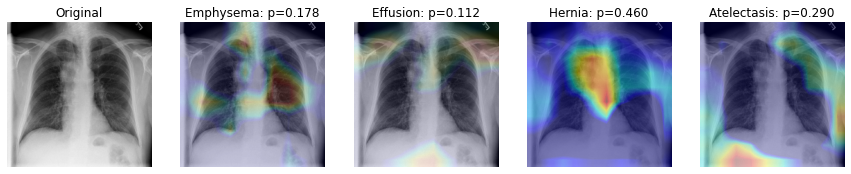

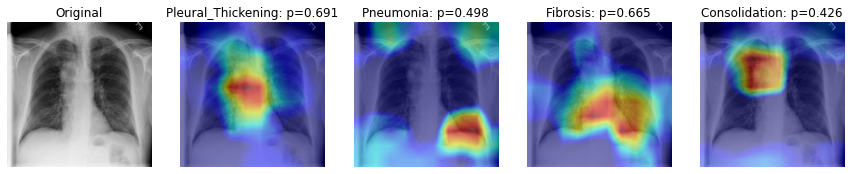

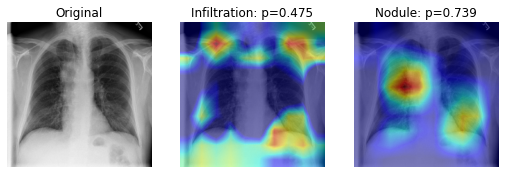

In [30]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show_1)
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show_2)
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show_3)
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show_4)